In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import efficientnet
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
RANDOM_SEED: int = 42

tf.random.set_seed(RANDOM_SEED)

In [ ]:
# Load train and validation datasets from the original folder
train_ds, val_ds = image_dataset_from_directory(
    directory='../data/raw',    
    labels='inferred',          
    label_mode='int',           
    image_size=(256, 256),      
    shuffle=True,               
    seed=42,                    
    validation_split=0.1,       
    subset='both',              
    pad_to_aspect_ratio=True,   
    batch_size=16         
)

# Save datasets
os.makedirs('../data/processed', exist_ok=True)
train_ds.save('../data/processed/train')
val_ds.save('../data/processed/val')


Found 688 files belonging to 3 classes.
Using 620 files for training.
Using 68 files for validation.


2025-11-25 16:23:33.757193: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-25 16:23:33.757493: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-25 16:23:33.757505: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-25 16:23:33.757918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-25 16:23:33.757955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE: int = 16
IMG_SHAPE = (256, 256, 3)

In [6]:
# Load tensor dataset
train_ds = Dataset.load('../data/processed/train')
val_ds = Dataset.load('../data/processed/val')


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



### Multi-Part Models

Now that we have several different compontents to our model we can initialize them separately for better organization. The `name` parameter can help keep things organized.

In [7]:
# --- Image Augmentor ----
data_augmentor = keras.Sequential([
    # Randomized augmentations
    layers.RandomFlip("horizontal", seed=RANDOM_SEED),
    layers.RandomRotation(0.1, seed=RANDOM_SEED),
    layers.RandomContrast(factor=1, seed=RANDOM_SEED),
], name='augmentation_block')


We use a Lambda layer to turn that preprocessing into a keras layer so we can put it inside the pipeline.

In [8]:
# --- Preprocessor ---
# Preprocessing for EfficientNet architecture
preprocessor = layers.Lambda(efficientnet.preprocess_input, name='preprocessor')

Now we can bring in the pretrained model.

In [9]:
# --- Feature Extractor (also called "The Backbone") ---
feature_extractor = efficientnet.EfficientNetB3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze weights
feature_extractor.trainable = False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# --- Classifier ---
classifier = keras.Sequential([

    # Flattening input
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),

    # Dense hidden layer with dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(3, activation='softmax')

], name='classification_head')

In [11]:
# Combining the modules
model = keras.Sequential([
    layers.Input(shape=IMG_SHAPE),
    data_augmentor, #augmenting before scaling is more efficient
    preprocessor,
    feature_extractor,
    classifier
], name='full_pipeline')

model.summary()

Model: "full_pipeline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_block (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessor (Lambda)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 3)              │       197,123 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980,658 (41.89 MB)

 Trainable params: 197,123 (770.01 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

## Training

In [12]:
# Initializing early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=8, #number of epochs of no improvement before training is stopped
    restore_best_weights=True #revert weights back to what they were before the plateau (undo overfitting)
)

In [13]:
# Initializing AdamW with weight decay
adamw_optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
)

In [14]:
# Compile model with new optimizer
model.compile(
    optimizer=adamw_optimizer,
    loss='sparse_categorical_crossentropy', #for multiclass problems
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=60, #maximum epochs, may stop before this now that we have early stopping
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/60


2025-11-25 16:23:42.755401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.5387 - loss: 1.0704 - val_accuracy: 0.8971 - val_loss: 0.3988
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.7613 - loss: 0.6108 - val_accuracy: 0.9118 - val_loss: 0.2977
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.8548 - loss: 0.3806 - val_accuracy: 0.9559 - val_loss: 0.2013
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.8548 - loss: 0.3469 - val_accuracy: 0.9412 - val_loss: 0.2087
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.8935 - loss: 0.2950 - val_accuracy: 0.9559 - val_loss: 0.1945
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.8984 - loss: 0.2562 - val_accuracy: 0.9706 - val_loss: 0.1995
Epoch 7/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.8952 - loss: 0.2897 - val_accuracy: 0.9706 - val_loss: 0.1308
Epoch 8/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9258 - loss: 0.2018 - val_accuracy: 0.9706 - va

In [25]:
# Unfreeze the last few layers of the feature extractor
for layer in feature_extractor.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import AdamW
fine_tune_optimizer = AdamW(learning_rate=1e-4)

model.compile(
    optimizer=fine_tune_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_fine = model.fit(
    train_ds,
    epochs=20,  # fewer epochs for fine-tuning
    validation_data=val_ds,
    callbacks=[es]
)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 55s 935ms/step - accuracy: 0.9565 - loss: 0.1495 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 540ms/step - accuracy: 0.9548 - loss: 0.1475 - val_accuracy: 0.9706 - val_loss: 0.0571
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.9742 - loss: 0.0729 - val_accuracy: 0.9853 - val_loss: 0.0221
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.9758 - loss: 0.0742 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.9871 - loss: 0.0499 - val_accuracy: 0.9853 - val_loss: 0.0351
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 483ms/step - accuracy: 0.9871 - loss: 0.0590 - val_accuracy: 1.0000 - val_loss: 0.0170
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.9839 - loss: 0.0298 - val_accuracy: 0.9853 - val_loss: 0.0286
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.9871 - loss: 0.0454 - val_accu

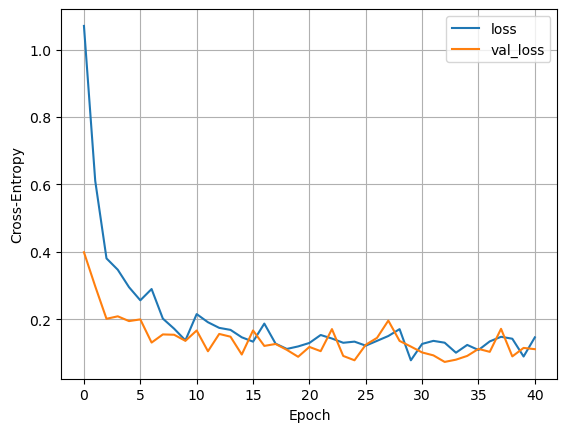

In [26]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.grid(True)

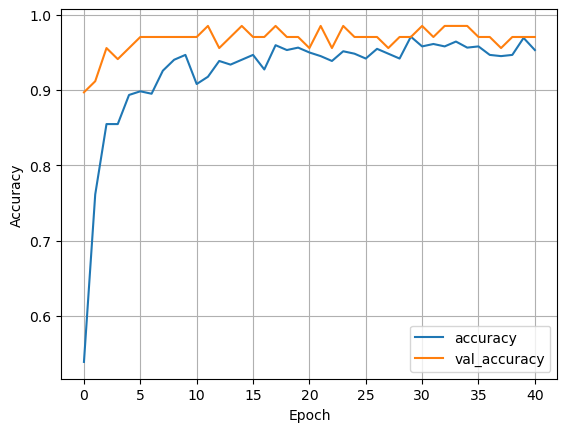

In [27]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [28]:
# Making predictions for the test set
test_probs: np.array = model.predict(val_ds)
# Converting probabilities into specific predictions
test_preds: np.array = np.argmax(test_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 


In [29]:
# Extracting y_test

# Unpack batch labels from val_ds
y_test_batches: list[np.ndarray] = [y for x, y in val_ds]
# Concatonate batches
y_test: np.ndarray = np.concatenate(y_test_batches)

2025-11-25 21:50:16.376824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
# Examining scores
class_names: list[str] = ['A', 'B', 'C']

print(classification_report(y_test, test_preds, target_names=class_names))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        23
           B       1.00      1.00      1.00        24
           C       1.00      1.00      1.00        21

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



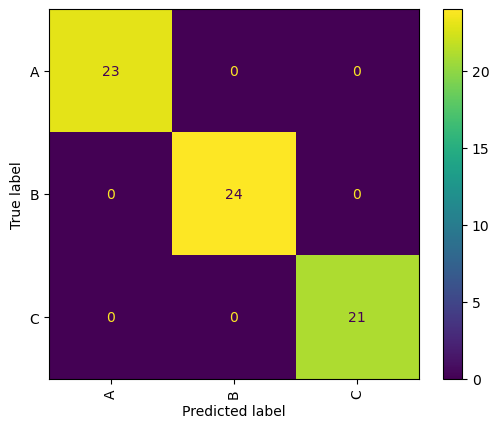

In [31]:
# Displaying confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=test_preds,
    display_labels=class_names,
    xticks_rotation='vertical'
)

Let's take a look at some of it's predictions

2025-11-25 21:50:30.562218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


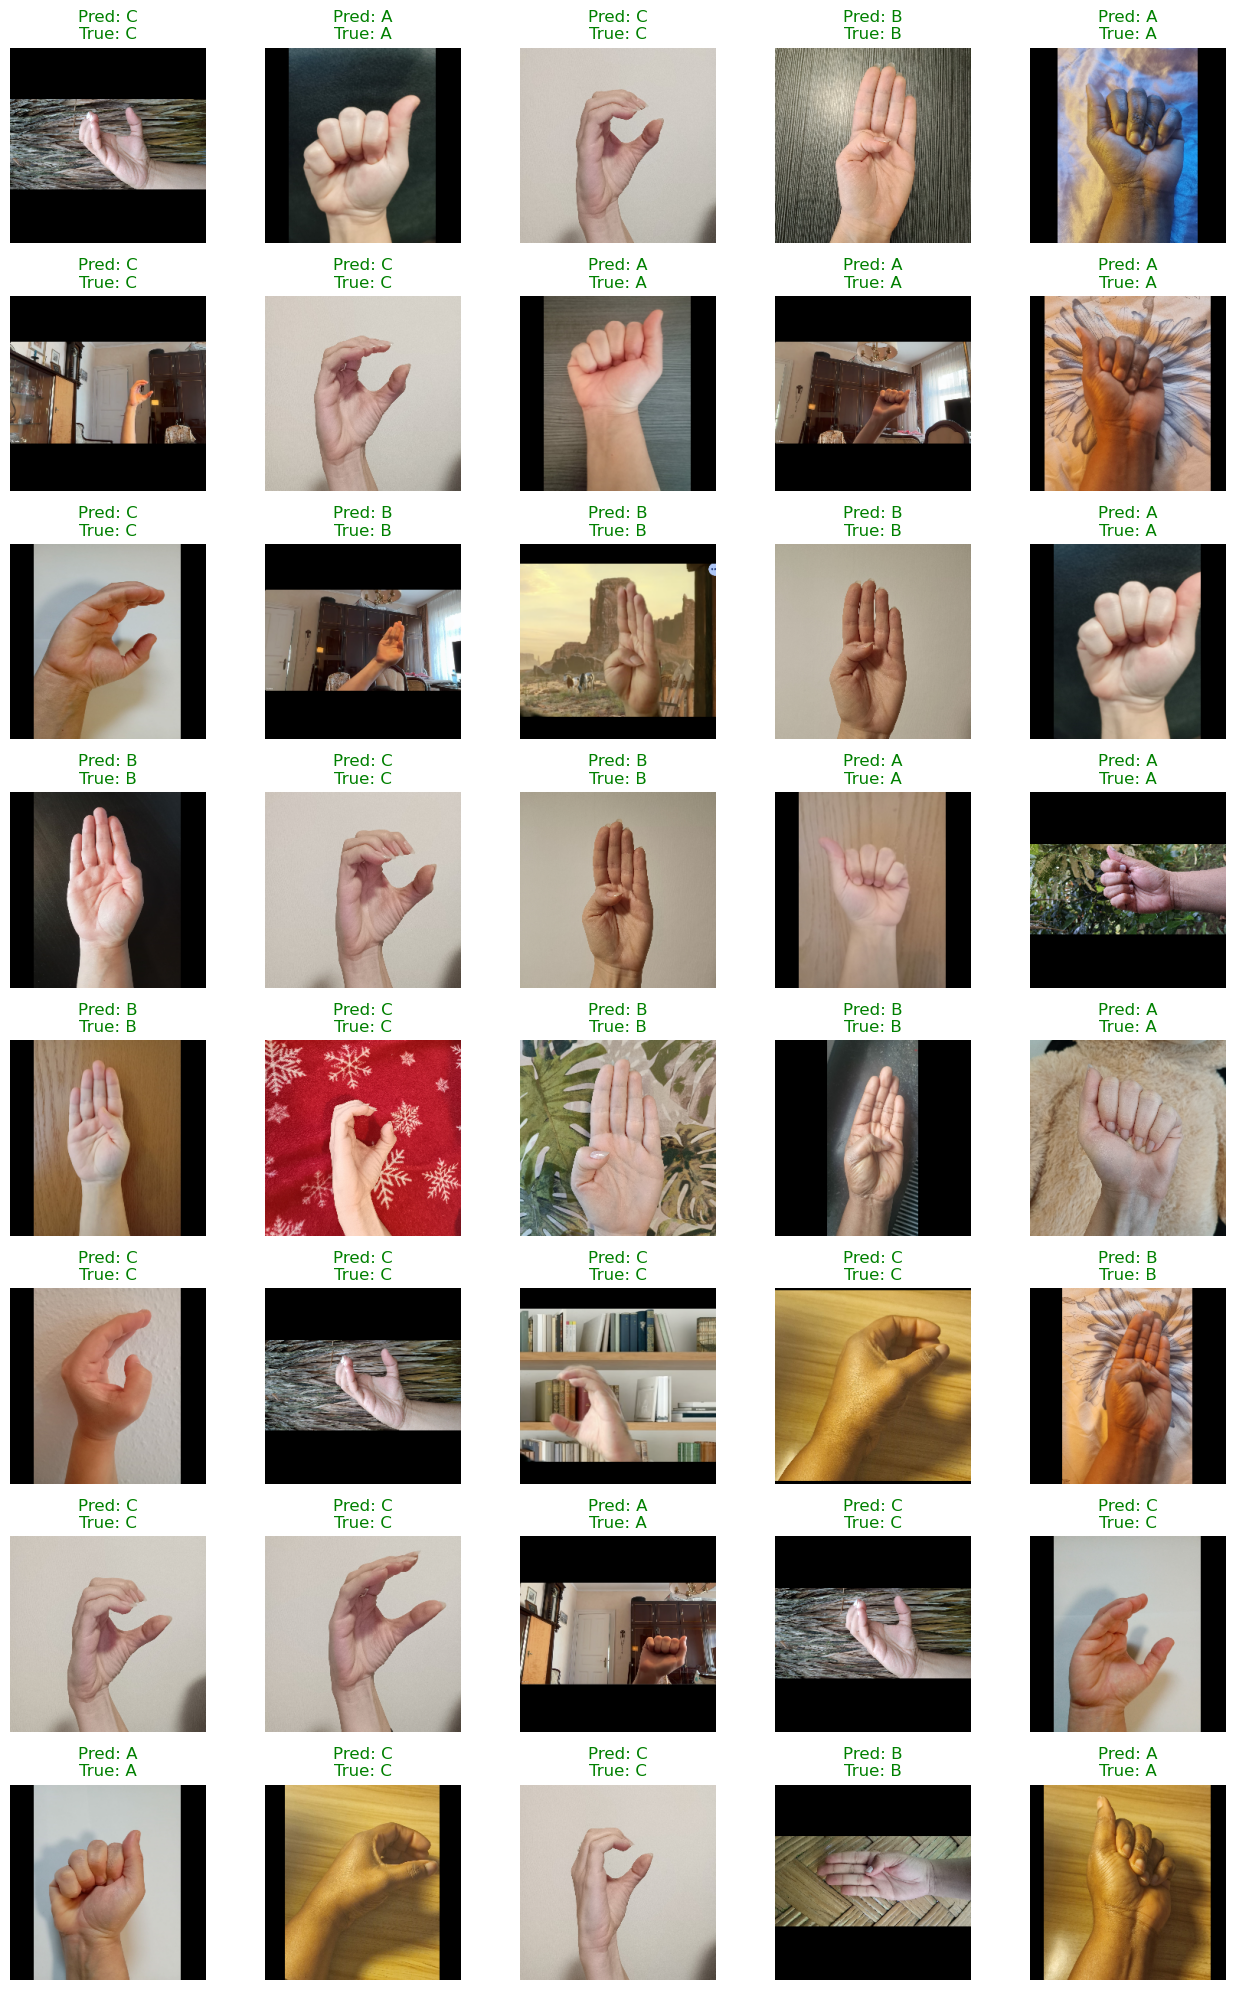

In [32]:
# Visualizing first 40 predictions
num_vis: int = 40

# Extracting images
batched_test_images: list[np.ndarray] = [X_batch for X_batch, y_batch in val_ds]
test_images: np.ndarray = np.concatenate(batched_test_images)

plt.figure(figsize=(int(num_vis/3),int(num_vis/2)))
columns=5

for i in range(num_vis):
    plt.subplot(int(num_vis/columns), columns, i+1)
    plt.imshow(test_images[i].astype('uint8'), cmap='gray')
    pred: int = test_preds[i]
    true: int = y_test[i]
    colour = 'green' if pred == true else 'red'
    plt.title(f'Pred: {class_names[pred]}\nTrue: {class_names[true]}', color=colour)
    plt.axis('off')

plt.tight_layout()
plt.show()